In [7]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Read data in as a pandas df
df = pd.read_csv("data_01_brains.txt", delimiter='\t')

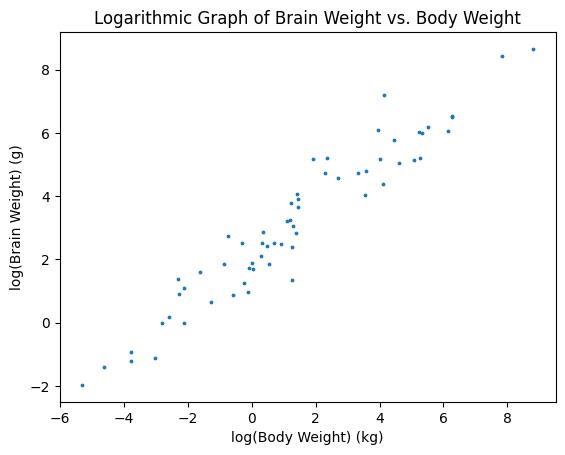

In [8]:
# Transform data to log-scale
df = df.assign(log_Body_Weight = lambda x: np.log(df['Body.Weight']),
          log_Brain_Weight = lambda x: np.log(df['Brain.Weight']))

# Visualize transformed data
x = df['log_Body_Weight'].to_numpy()
y = df['log_Brain_Weight'].to_numpy()

plt.scatter(x, y, s=3)
plt.xlabel("log(Body Weight) (kg)")
plt.ylabel("log(Brain Weight) (g)")
plt.title("Logarithmic Graph of Brain Weight vs. Body Weight")
plt.show()

In [16]:
# Calculate Regression Coefficients (math approach)
mean_x = np.mean(x)
mean_y = np.mean(y)
numerator = np.sum((x - mean_x) * (y - mean_y))
denominator = np.sum((x - mean_x) ** 2)
m = numerator/denominator
b = mean_y - m * mean_x
print("Coefficient: ", m)
print("Intercept: ", b)


Coefficient:  0.7516859362419007
Intercept:  2.134788676764636


In [14]:
from sklearn.linear_model import LinearRegression

# Calculate Regression Coefficients (using built-in libraries)
model = LinearRegression()
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(f'Coefficient: {model.coef_}')
print(f'Intercept: {model.intercept_}')


Coefficient: [[0.75168594]]
Intercept: [2.13478868]


For every unit increase in X, the predicted value of y increased by 75%. 

In [17]:
import statsmodels.api as sm

X_const = sm.add_constant(x)
model_sm = sm.OLS(y, X_const).fit()

# Display the summary
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     697.4
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           9.84e-35
Time:                        00:25:03   Log-Likelihood:                -64.336
No. Observations:                  62   AIC:                             132.7
Df Residuals:                      60   BIC:                             136.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1348      0.096     22.227      0.0

# LASSO

Run 'pip install rdkit-pypi' before this section

In [18]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

#more datasets here: https://github.com/RekerLab/DeepDelta/tree/main/Datasets/Benchmarks
url = "https://raw.githubusercontent.com/RekerLab/DeepDelta/main/Datasets/Benchmarks/HemoTox.csv"
c = pd.read_csv(url)

# look at the top of this dataset
print(c.head())

# convert SMILES to molecules
mols = [Chem.MolFromSmiles(s) for s in c['SMILES']]

# create binary fingerprints for robust ML models
fps = np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(m,2)) for m in mols])

# create descriptors for ML models with higher interpretability
from rdkit.Chem import Descriptors
descr = Descriptors._descList
calc = [x[1] for x in descr]
d_name = [x[0] for x in descr]

desc = np.array([np.array([f(m) for f in calc]) for m in mols])

# Convert the numpy array to a pandas DataFrame with descriptor names as columns
X = pd.DataFrame(desc, columns=d_name)
# extract y values from original dataframe into separate vector
y = c['Y']

                                              SMILES      Y
0  CC(C)(C)c1cc(N)c(SCCN)c(NC(=O)c2cccc(C(=O)Nc3c...  1.146
1  COc1cc(OC)c(C(=O)Nc2cc(C(C)(C)C)cc(N)c2SCCN)cc...  2.161
2  CC(C)(C)c1cc(N)c(SCCN)c(NC(=O)c2cc(OCCN)cc(C(=...  2.037
3  CC(C)(C)c1cc(N)c(SCCNC(N)=[NH2+])c(NC(=O)c2cc(...  1.987
4  NCCSc1c(NC(=O)CCCCNC(N)=[NH2+])cc(C(F)(F)F)cc1...  1.786


In [19]:
from sklearn.feature_selection import VarianceThreshold
print("Original shape of feature data:", X.shape)
missing = X.isna().sum().sum()
print("Total missing values:", missing)
X_new = X.dropna()
print("Shape of feature data after removing missing observations:", X_new.shape)
selector = VarianceThreshold()
X_new = selector.fit_transform(X_new)
print("Total 0-variance features:", X.shape[1] - X_new.shape[1])
print("Shape of feature data after removing 0-variance features:", X_new.shape)
X_new = pd.DataFrame(X_new, columns=X.columns[selector.get_support()])

Original shape of feature data: (828, 208)
Total missing values: 0
Shape of feature data after removing missing observations: (828, 208)
Total 0-variance features: 28
Shape of feature data after removing 0-variance features: (828, 180)


In [23]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=12)

##❓YOUR CODE HERE

# Initialize the Lasso model
clf = Lasso(alpha=0.1, random_state=42)
# fit the model
clf.fit(X_train, y_train)
# Get the coefficients and their corresponding feature names
coeff = clf.coef_
coeff_df = pd.DataFrame({'Feature': X_new.columns, 'Coefficient': coeff})
coeff_df['Absolute Value'] = coeff_df['Coefficient'].abs()
# sort and display the top coefficients with their feature names
sorted_coeff = coeff_df.sort_values(by='Absolute Value', ascending=False)
# Print the top 10 features with the largest coefficients
sorted_coeff.head(10)

,Feature,Coefficient,Absolute Value
18,BCUT2D_CHGHI,-0.144847,0.144847
115,NumSaturatedHeterocycles,-0.133519,0.133519
160,fr_lactone,-0.131667,0.131667
13,FpDensityMorgan1,0.112480,0.112480
24,BalabanJ,0.064812,0.064812
63,SMR_VSA5,-0.019528,0.019528
99,VSA_EState9,0.013137,0.013137
98,VSA_EState8,-0.009438,0.009438
130,fr_C_O,-0.000000,0.000000
121,fr_Al_OH,-0.000000,0.000000


In [24]:
##❓YOUR CODE HERE
# Predict on the test set using the fitted model
y_pred = clf.predict(X_test)

# Calculate the R^2 value and print
r2 = r2_score(y_test, y_pred)
print(f"R^2 value of the LASSO model on test data: {r2:.4f}")

R^2 value of the LASSO model on test data: 0.4543
